In [ ]:
pip install Sastrawi

In [ ]:
import pandas as pd
import numpy as np
import re
import json
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

In [ ]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
data = pd.read_excel('Review Pahamify.xlsx')
data.head()

,Unnamed: 0,content,score
0,0,"buruk, terutama dalam penjelasan Mtk.. kebanya...",1
1,1,"masih ada sedikit bug, tapi masih ok, pembahas...",4
2,2,masyaAllah semoga berkah ilmunya,5
3,3,"Sangat cocok untuk belajar, apalagi fitur TryO...",5
4,4,Rekomended +++,5


In [ ]:
# Inisialisasi objek preprocessing
stop_words = set(stopwords.words('indonesian'))

# Membaca slangword dari file .txt
def load_slangwords(file_path):
    with open(file_path, 'r') as file:
        slang_dict = json.load(file)
    return slang_dict

def create_reverse_slang_dict(slang_dict):
    reverse_slang_dict = {}
    for formal, slangs in slang_dict.items():
        for slang in slangs:
            reverse_slang_dict[slang] = formal
    return reverse_slang_dict

# Memuat slangwords
slang_dict = load_slangwords('slang_words.txt')
reverse_slang_dict = create_reverse_slang_dict(slang_dict)

def remove_emojis(text):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F700-\U0001F77F"  # alchemical symbols
                               u"\U0001F780-\U0001F7FF"  # Geometric Shapes Extended
                               u"\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
                               u"\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
                               u"\U0001FA00-\U0001FA6F"  # Chess Symbols
                               u"\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
                               u"\U00002702-\U000027B0"  # Dingbats
                               u"\U000024C2-\U0001F251"
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

def normalize_slangwords(text, slang_dict):
    words = text.split()
    normalized_words = [slang_dict.get(word, word) for word in words]
    return ' '.join(normalized_words)

# Membuat stemmer bahasa Indonesia
factory = StemmerFactory()
stemmer = factory.create_stemmer()

def preprocess_text(text):
    # Ubah menjadi huruf kecil
    text = text.lower()
    # Hapus emoji
    text = remove_emojis(text)
    # Hapus angka
    text = re.sub(r'\d+', '', text)
    # Hapus tanda baca dan karakter non-alfabet
    text = re.sub(r'[^a-z\s]', '', text)
    # Normalisasi slangword
    text = normalize_slangwords(text, reverse_slang_dict)
    # Tokenisasi
    tokens = word_tokenize(text)
    # Hapus stopword
    tokens = [word for word in tokens if word not in stop_words]
    # Stemming dengan Sastrawi
    tokens = [stemmer.stem(word) for word in tokens]
    return ' '.join(tokens)

# Terapkan preprocessing pada kolom komentar
data['clean'] = data['content'].apply(preprocess_text)

# Menampilkan data yang sudah di-preprocess
data.head()


,Unnamed: 0,content,score,clean
0,0,"buruk, terutama dalam penjelasan Mtk.. kebanya...",1,buruk jelas mtk banyak ngomong otomatis diberi...
1,1,"masih ada sedikit bug, tapi masih ok, pembahas...",4,bug ok bahas enak
2,2,masyaAllah semoga berkah ilmunya,5,masyaallah moga berkah ilmu
3,3,"Sangat cocok untuk belajar, apalagi fitur TryO...",5,cocok ajar fitur tryout kali versi gratis
4,4,Rekomended +++,5,recommended


In [ ]:
data.to_excel('dataclean.xlsx')

**TF-IDF TRANSFORMATION**

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
# Vectorisasi teks menggunakan TF-IDF
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(data['content'])

# X sekarang berisi representasi vektor TF-IDF dari komentar yang dapat digunakan untuk K-Means

In [ ]:
import matplotlib.pyplot as plt


# Transformasi data dengan TF-IDF
X = vectorizer.fit_transform(data['content']).toarray()

In [ ]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(data['content'])

In [ ]:
# Ubah tfidf_matrix menjadi DataFrame
df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())

In [ ]:
df.to_excel('tf-idf.xlsx')

**K-MEANS CLUSTERING**

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

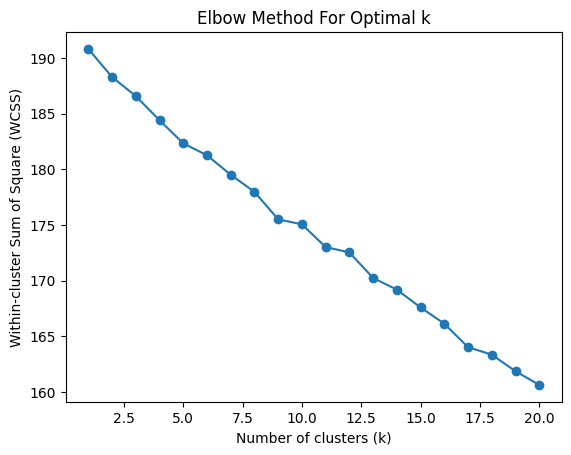

In [ ]:
# Hitung WCSS untuk berbagai jumlah klaster
wcss = []
max_k = 20
for k in range(1, max_k + 1):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)

# Plot WCSS vs. jumlah klaster
plt.plot(range(1, max_k + 1), wcss, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Within-cluster Sum of Square (WCSS)')
plt.title('Elbow Method For Optimal k')
plt.show()

In [ ]:
num_clusters = 8  # Jumlah cluster yang diinginkan
kmeans = KMeans(n_clusters=num_clusters)
kmeans.fit(X)

KMeans()

In [ ]:
# Mendapatkan label cluster untuk setiap teks
cluster_labels = kmeans.labels_

clustered_data = {}
for i in range(num_clusters):
    clustered_data[i] = data[cluster_labels == i]

In [ ]:
# Menampilkan hasil clustering
for i in range(num_clusters):
    print(f"Cluster {i}:")
    for j, text in enumerate(data['clean']):
        if cluster_labels[j] == i:
            print(f"- {text}")
    print()

Cluster 0:
- masyaallah moga berkah ilmu
- moga lolos snbt aamiin
- keren moga lulus snbp aamiin
- lolos snbt aamiin
- bismillah lulus snbt

Cluster 1:
- kalo ganti resolusi p aplikasi langsung
- to tbtb suruh login login device kali jg instal
- min apps pahamify dihpku gabisa buka yah
- ajar tarik mudah erti download video tonton ujungujungnya nggak buka video henti tengahtengah video udah didownload buka suruh beli langgan udah langgan habis kuota download video nggak buka
- bug
- apknya error sih try out tolong upgrade error bug
- apknya buka
- aplikasi kurikulum merdeka kurikulum merdeka mata ajar projek kuat profil ajar pancasila p maksud tambah mata ajar kurikulum merdeka gratis aplikasi suka aplikasi mohon baik terimakasih bantu anak sekolah siswa siswi smp sma tingkat guru thanks you
- beli premium download nonton offline pas kemarin kuota habis puter online biar tau akun premium sulit download
- jujur aplikasi bantu banget suka bagi sistem
- aplikasi guna bayar premium materi 

In [ ]:
# Menambahkan kolom label klaster ke DataFrame
data['cluster'] = cluster_labels

In [ ]:
data.head()

,Unnamed: 0.1,Unnamed: 0,content,score,clean,sentiment_label,label,cluster
0,0,0,keren mantap,5,keren mantap,1,1,2
1,1,1,mudah untuk di pelajari,4,mudah ajar,1,1,0
2,2,2,Aplikasi nya keren dan banyak juga logo logo n...,5,aplikasi keren logo logo pilih,1,1,0
3,3,3,sangat membantu sekali untuk para guru dan par...,5,bantu guru siswa giat ajar,1,1,0
4,4,4,bagus sekali,4,bagus,1,1,1


In [ ]:
data.to_excel('klasterlabel.xlsx')

Wordcloud untuk Klaster 1:


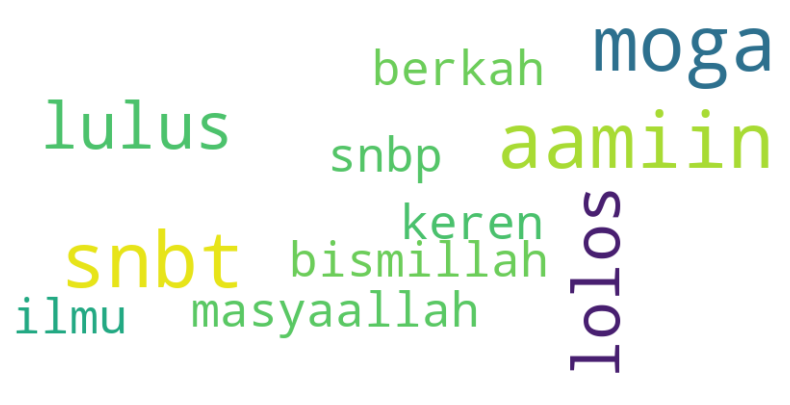

Wordcloud untuk Klaster 2:


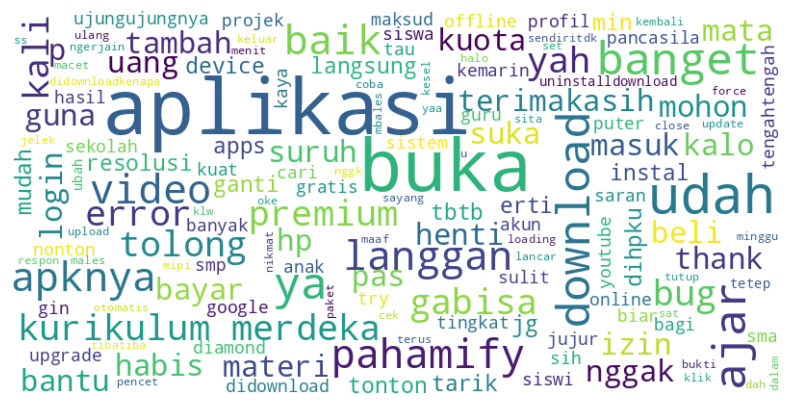

Wordcloud untuk Klaster 3:


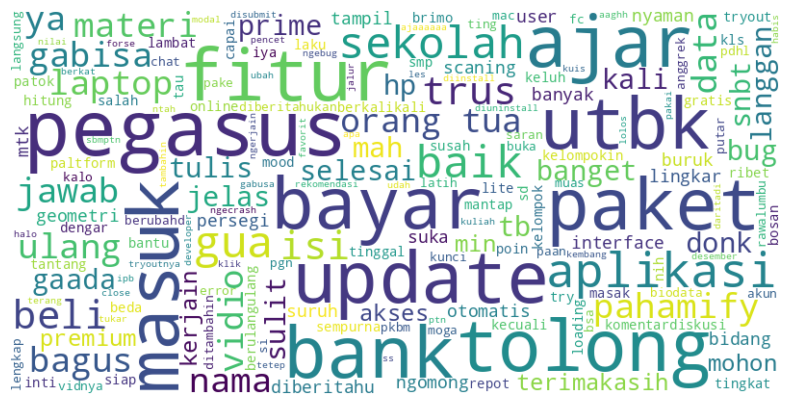

Wordcloud untuk Klaster 4:


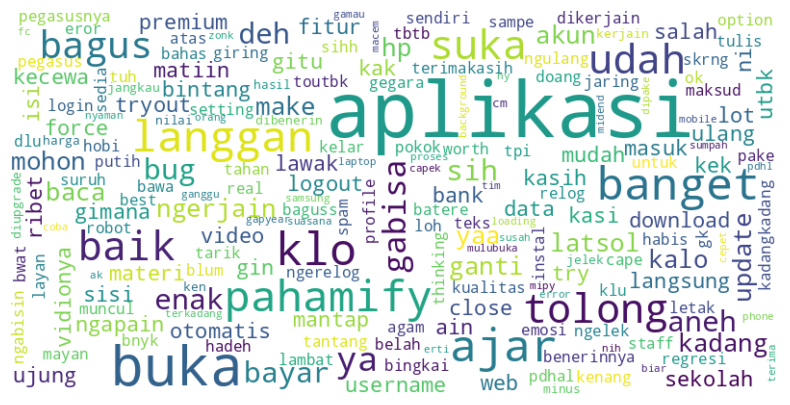

Wordcloud untuk Klaster 5:


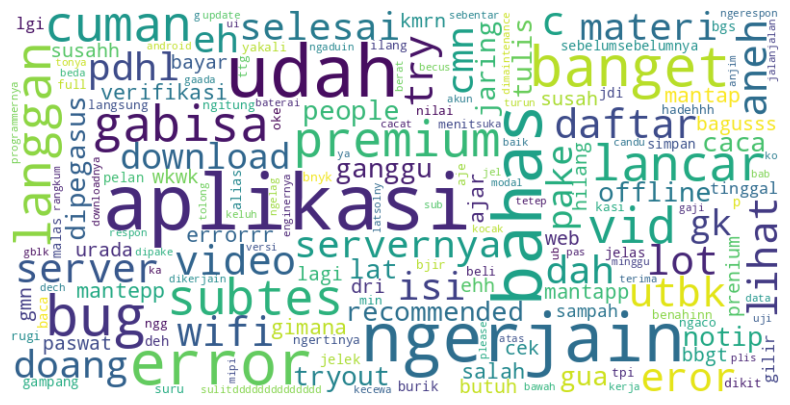

Wordcloud untuk Klaster 6:


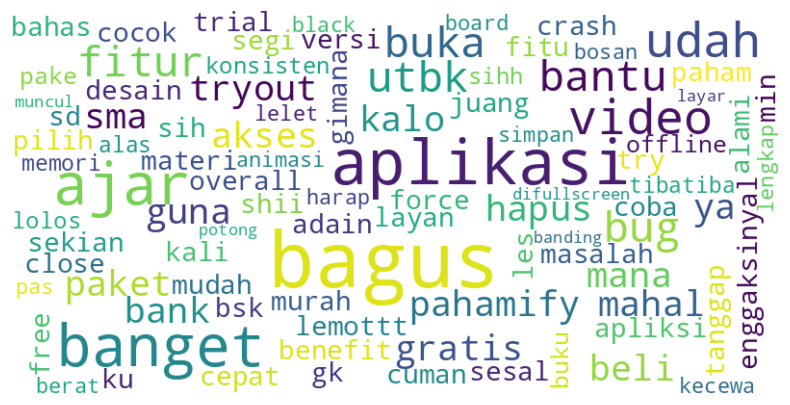

Wordcloud untuk Klaster 7:


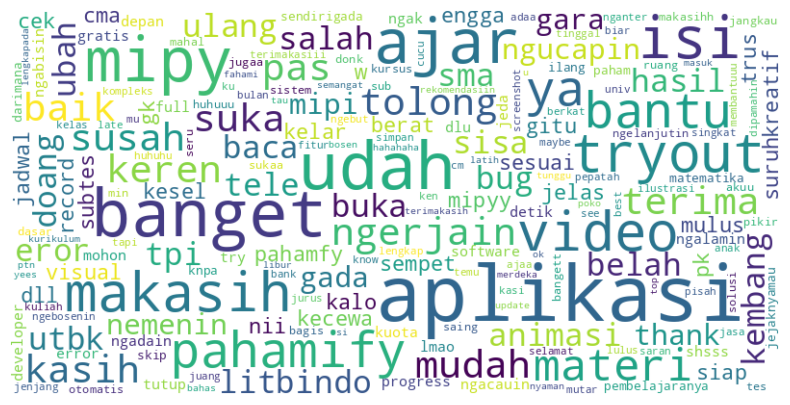

Wordcloud untuk Klaster 8:


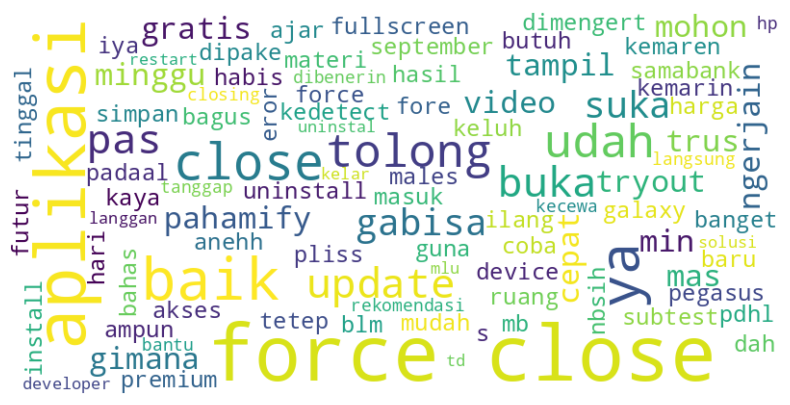

In [ ]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Fungsi untuk membuat wordcloud
def create_wordcloud(text, colormap):
    wordcloud = WordCloud(width=800, height=400,
                          background_color='white',
                          colormap=colormap,
                          stopwords=STOPWORDS,
                          max_font_size=80,
                          contour_width=3,
                          contour_color='steelblue').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

# Buat daftar colormap yang berbeda untuk setiap klaster
colormaps = ['viridis', 'viridis', 'viridis', 'viridis']

# Buat wordcloud untuk setiap klaster
for i in range(num_clusters):
    cluster_text = ' '.join(clustered_data[i]['clean'])
    print(f"Wordcloud untuk Klaster {i+1}:")
    create_wordcloud(cluster_text, colormaps[i % len(colormaps)])

In [ ]:
# Menghitung silhouette score
from sklearn.metrics import silhouette_score

sil_score = silhouette_score(X, cluster_labels)
print(f'Silhouette Score: {sil_score}')

Silhouette Score: 0.014219594960660473
